## Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
import matplotlib.patches as patches

In [3]:
# Visualize annotations related to segmented objects within an image
# anns: a list of annotations
def show_anns(anns):
    if len(anns) == 0:
        return
    
    # Sort the annotations by area
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca() # get current axes
    ax.set_autoscale_on(False) # disables autoscaling for the axis

    # Initialize an empty image with the same dimmensions as the segmentation mask of the annotation with the largest area
    # The image has four channels (RGBA), where the alpha channel is initially set to 0, making it transparent
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    # Iterates through the sorted annotations
    for ann in sorted_anns:
        # Retrieves the segmentation mask from the annotation
        m = ann['segmentation']

        # Generates a random color represented as an RGB tuple and sets the alpha channel to `alpha`.
        # This creates a semi-transparent color for the annotation.
        alpha = 0.4
        color_mask = np.concatenate([np.random.random(3), [alpha]])

        # Assigns this color to the corresponding pixels in the `img` using the segmentation mask `m`
        img[m] = color_mask
    
    # Displays the resulting `img` on the current axis
    ax.imshow(img)

## Example image

In [4]:
image = cv2.imread('images/cup-0011-gt.png') # Read as RGB image
# image = cv2.imread('images/step_500_10_pred_masked.png')
# image = cv2.imread('images/step_500_10_pred_nomask.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
print(image.shape)

(1080, 1920, 3)


In [6]:
image_height, image_width = image.shape[0], image.shape[1]
print(image_height)
print(image_width)

1080
1920


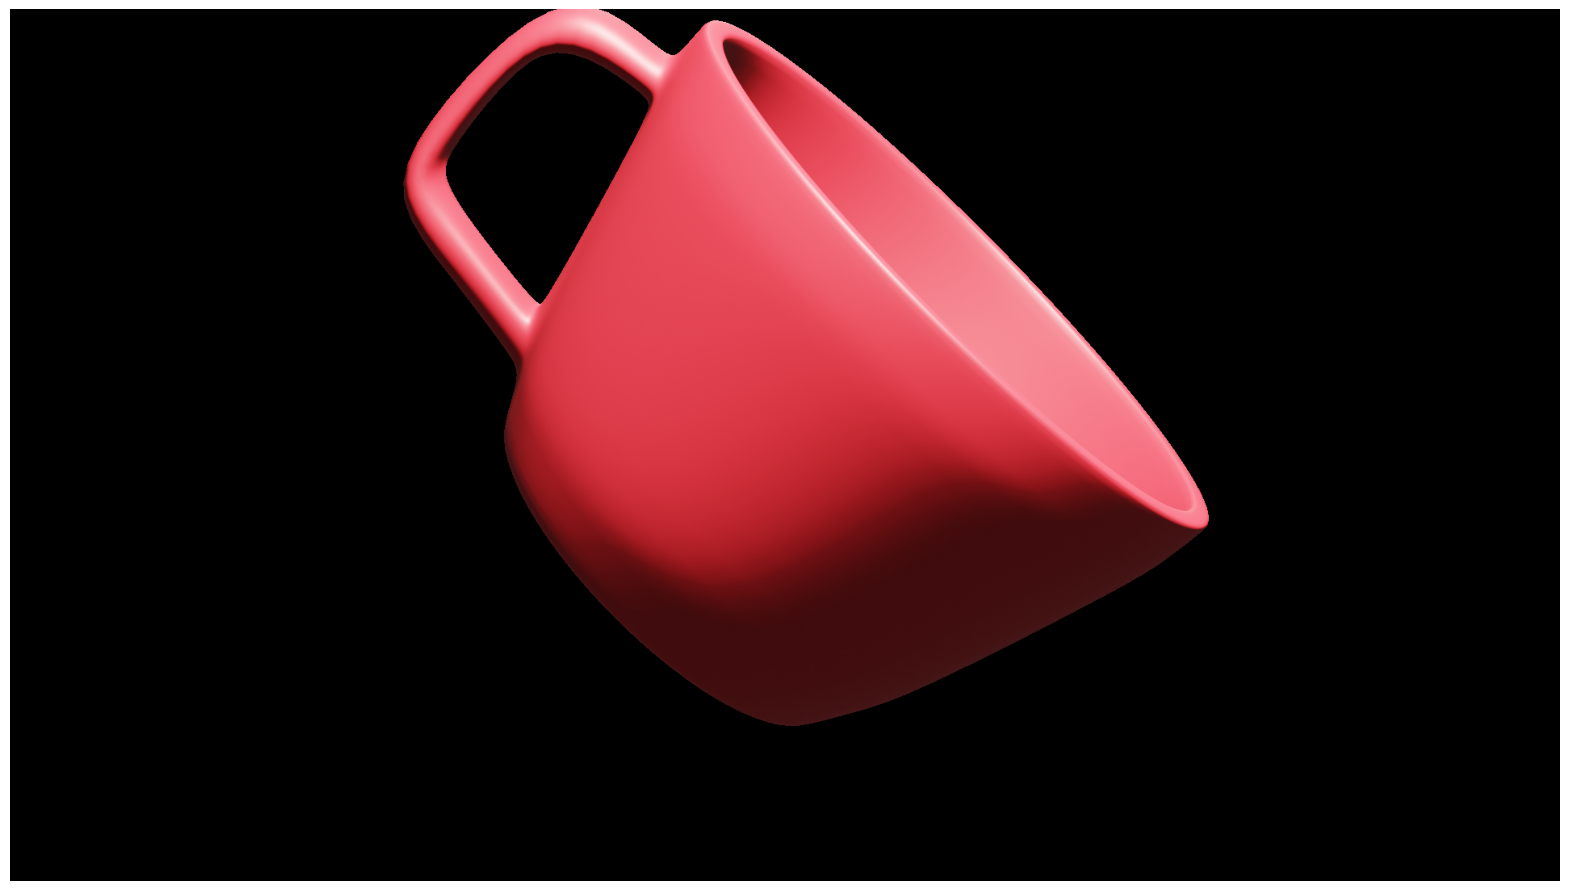

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/home/kz/Desktop/Research/SAM/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

# sam = build_sam_vit_h(checkpoint="sam_vit_h_4b8939.pth")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) 
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8, # Number of points to be sampled along one side of the image. Total number of points is this squared.
    min_mask_region_area=100,  # Requires open-cv to run post-processing; filter small disconnected regions and holes in masks the have smaller region than this value.
)

# Prompt Embeddings

In [9]:
# A grid of prompt points evenly spaced in [0, 1] x [0, 1]
all_points = mask_generator.point_grids[0]
print(all_points.shape)

(64, 2)


In [10]:
print(np.array(image.shape[:2]))

[1080 1920]


In [11]:
cropped_im_size = image.shape[:2]
print(cropped_im_size)
points_scale = np.array(cropped_im_size)[None, ::-1]
print(points_scale)

(1080, 1920)
[[1920 1080]]


In [12]:
points_for_image = all_points * points_scale
print(points_for_image)

[[ 120.    67.5]
 [ 360.    67.5]
 [ 600.    67.5]
 [ 840.    67.5]
 [1080.    67.5]
 [1320.    67.5]
 [1560.    67.5]
 [1800.    67.5]
 [ 120.   202.5]
 [ 360.   202.5]
 [ 600.   202.5]
 [ 840.   202.5]
 [1080.   202.5]
 [1320.   202.5]
 [1560.   202.5]
 [1800.   202.5]
 [ 120.   337.5]
 [ 360.   337.5]
 [ 600.   337.5]
 [ 840.   337.5]
 [1080.   337.5]
 [1320.   337.5]
 [1560.   337.5]
 [1800.   337.5]
 [ 120.   472.5]
 [ 360.   472.5]
 [ 600.   472.5]
 [ 840.   472.5]
 [1080.   472.5]
 [1320.   472.5]
 [1560.   472.5]
 [1800.   472.5]
 [ 120.   607.5]
 [ 360.   607.5]
 [ 600.   607.5]
 [ 840.   607.5]
 [1080.   607.5]
 [1320.   607.5]
 [1560.   607.5]
 [1800.   607.5]
 [ 120.   742.5]
 [ 360.   742.5]
 [ 600.   742.5]
 [ 840.   742.5]
 [1080.   742.5]
 [1320.   742.5]
 [1560.   742.5]
 [1800.   742.5]
 [ 120.   877.5]
 [ 360.   877.5]
 [ 600.   877.5]
 [ 840.   877.5]
 [1080.   877.5]
 [1320.   877.5]
 [1560.   877.5]
 [1800.   877.5]
 [ 120.  1012.5]
 [ 360.  1012.5]
 [ 600.  1012.

In [13]:
batch_size = 64
# n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
#           64                    // 64         + int(64                    % 64         != 0)

n_batches = 64 // batch_size + int((64 % batch_size) != 0)

print(n_batches) 

1


In [14]:
def batch_iterator(batch_size: int, *args):
    # print("args[0] = ", args[0])
    n_batches = len(args[0]) // batch_size + int((len(args[0]) % batch_size) != 0) # Number of total batches
    # print("n_batches = ", n_batches)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

In [15]:
for (points,) in batch_iterator(64, points_for_image):
    print("points = ", points)

points =  [[ 120.    67.5]
 [ 360.    67.5]
 [ 600.    67.5]
 [ 840.    67.5]
 [1080.    67.5]
 [1320.    67.5]
 [1560.    67.5]
 [1800.    67.5]
 [ 120.   202.5]
 [ 360.   202.5]
 [ 600.   202.5]
 [ 840.   202.5]
 [1080.   202.5]
 [1320.   202.5]
 [1560.   202.5]
 [1800.   202.5]
 [ 120.   337.5]
 [ 360.   337.5]
 [ 600.   337.5]
 [ 840.   337.5]
 [1080.   337.5]
 [1320.   337.5]
 [1560.   337.5]
 [1800.   337.5]
 [ 120.   472.5]
 [ 360.   472.5]
 [ 600.   472.5]
 [ 840.   472.5]
 [1080.   472.5]
 [1320.   472.5]
 [1560.   472.5]
 [1800.   472.5]
 [ 120.   607.5]
 [ 360.   607.5]
 [ 600.   607.5]
 [ 840.   607.5]
 [1080.   607.5]
 [1320.   607.5]
 [1560.   607.5]
 [1800.   607.5]
 [ 120.   742.5]
 [ 360.   742.5]
 [ 600.   742.5]
 [ 840.   742.5]
 [1080.   742.5]
 [1320.   742.5]
 [1560.   742.5]
 [1800.   742.5]
 [ 120.   877.5]
 [ 360.   877.5]
 [ 600.   877.5]
 [ 840.   877.5]
 [1080.   877.5]
 [1320.   877.5]
 [1560.   877.5]
 [1800.   877.5]
 [ 120.  1012.5]
 [ 360.  1012.5]
 [ 6

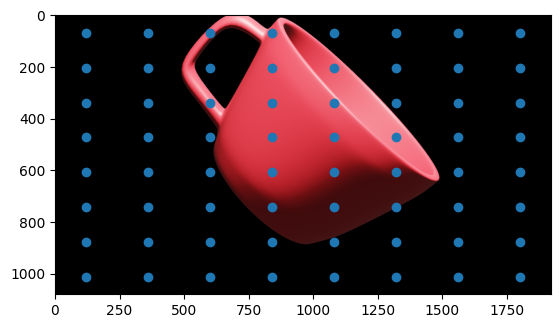

In [16]:
# plt.figure(figsize=(20,20))
plt.scatter(points_for_image[:, 0], points_for_image[:, 1], marker="o")
plt.imshow(image)
plt.show()

In [18]:
im_size = points_for_image.shape[:2]
print(im_size)

(64, 2)


In [19]:
transformed_points = mask_generator.predictor.transform.apply_coords(points_for_image, im_size)
in_points = torch.as_tensor(transformed_points, device=mask_generator.predictor.device) # batch_size x 2
in_labels = torch.ones(in_points.shape[0], dtype=torch.int, device=in_points.device) # batch_size x 1

print(in_points.shape)
print(in_labels.shape)

torch.Size([64, 2])
torch.Size([64])


In [20]:
point_coords = in_points[:, None, :]
point_labels = in_labels[:, None]
print(point_coords.shape)
print(point_labels.shape)

points = (point_coords, point_labels)

torch.Size([64, 1, 2])
torch.Size([64, 1])


In [21]:
sparse_embeddings, dense_embeddigns = mask_generator.predictor.model.prompt_encoder(
            points=points,
            boxes=None,
            masks=None,
        )

In [22]:
print(sparse_embeddings.shape)
print(dense_embeddigns.shape)

torch.Size([64, 2, 256])
torch.Size([64, 256, 64, 64])


In [24]:
fg_points_embeddings = sparse_embeddings[:, 0, :]
print(fg_points_embeddings.shape)

bg_points_embeddings = sparse_embeddings[:, 1, :]
print(bg_points_embeddings.shape)

fg_img = fg_points_embeddings.cpu().detach().numpy()
print(fg_img.shape)

bg_img = bg_points_embeddings.cpu().detach().numpy()
print(bg_img.shape)

torch.Size([64, 256])
torch.Size([64, 256])
(64, 256)
(64, 256)


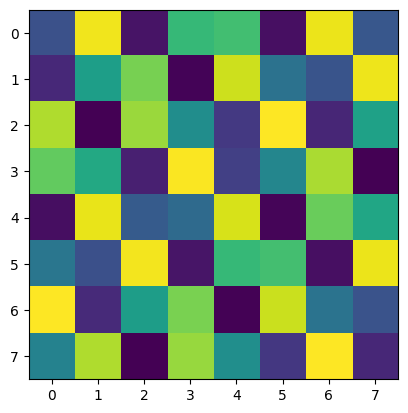

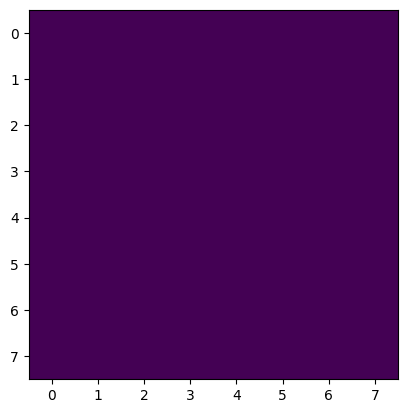

In [25]:
img1 = fg_img.reshape(8, 8, 256)
plt.imshow(img1[:, :, 0], cmap='viridis')
plt.show()

img2 = bg_img.reshape(8, 8, 256)
plt.imshow(img2[:, :, 0], cmap='viridis')
plt.show()

# Generating the Masks

To generate masks, just run `generate` on an image.

In [26]:
masks = mask_generator.generate(image)

In [27]:
print("Total number of masks = ", len(masks))

Total number of masks =  5


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [23]:
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [24]:
print(masks[0])

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 489853, 'bbox': [490, 0, 992, 885], 'predicted_iou': 1.0169878005981445, 'point_coords': [[840.0, 607.5]], 'stability_score': 0.9936528205871582, 'crop_box': [0, 0, 1920, 1080]}


In [25]:
# The mask 
# Binary mask: True / 1 for masked area (white), False / 0 for background (black)
print(masks[0]['segmentation'].shape)
print(masks[0]['segmentation'])

(1080, 1920)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [26]:
y = 500
x = 800

In [27]:
print(masks[0]['segmentation'][y, x])

True


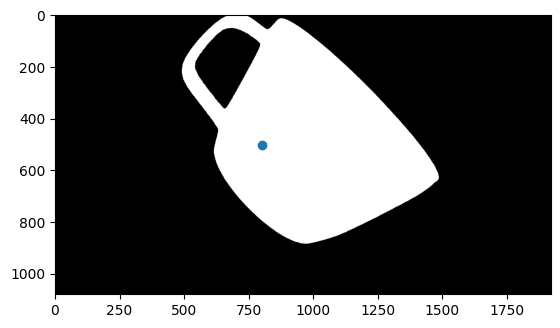

In [28]:
plt.imshow(masks[0]['segmentation'], cmap='gray')
plt.plot(x, y, marker="o")
plt.show()

[[840.0, 607.5]]
Point inside mask:  True


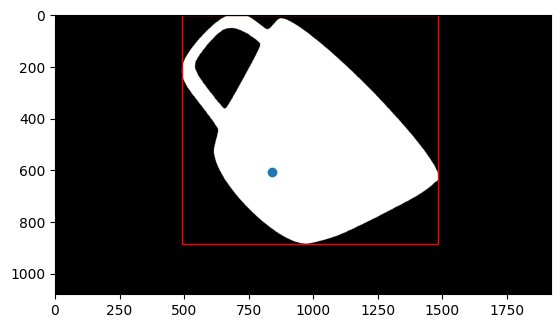

[[600.0, 472.5]]
Point inside mask:  True


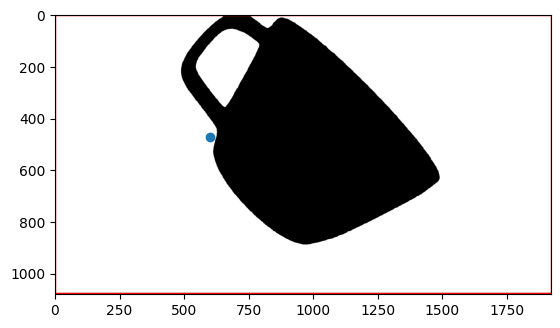

[[600.0, 67.5]]
Point inside mask:  True


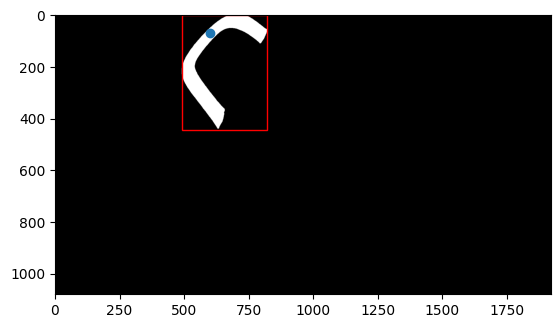

[[1320.0, 472.5]]
Point inside mask:  True


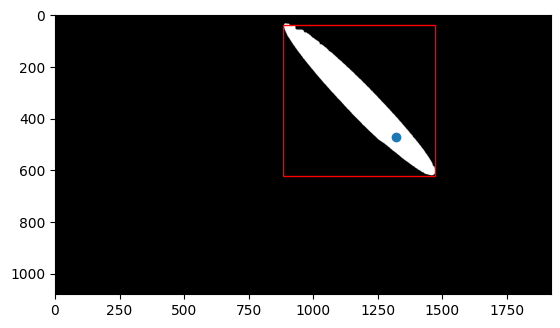

[[600.0, 202.5]]
Point inside mask:  True


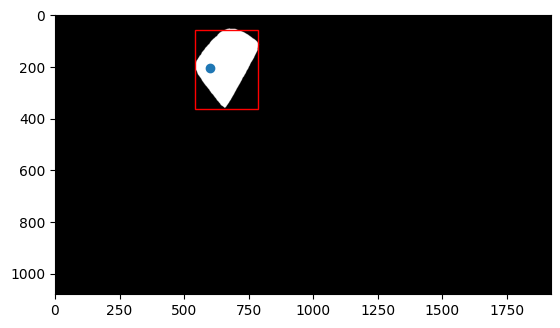

In [29]:
for mask in masks:
    segmented_mask = mask['segmentation']
    input_points = mask['point_coords']
    print(input_points)

    bb = mask['bbox']
    rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
    
    # values, counts = np.unique(segmented_mask, return_counts=True)
    # print(values)
    # print(counts)
    
    fig, ax = plt.subplots()
    ax.add_patch(rect)

    plt.imshow(segmented_mask, cmap='gray')
    for point in input_points:
        x, y = point[0], point[1]
        print("Point inside mask: ", segmented_mask[int(y), int(x)])
        plt.plot(x, y, marker="o")
    plt.show()



Show all the masks overlayed on the image.

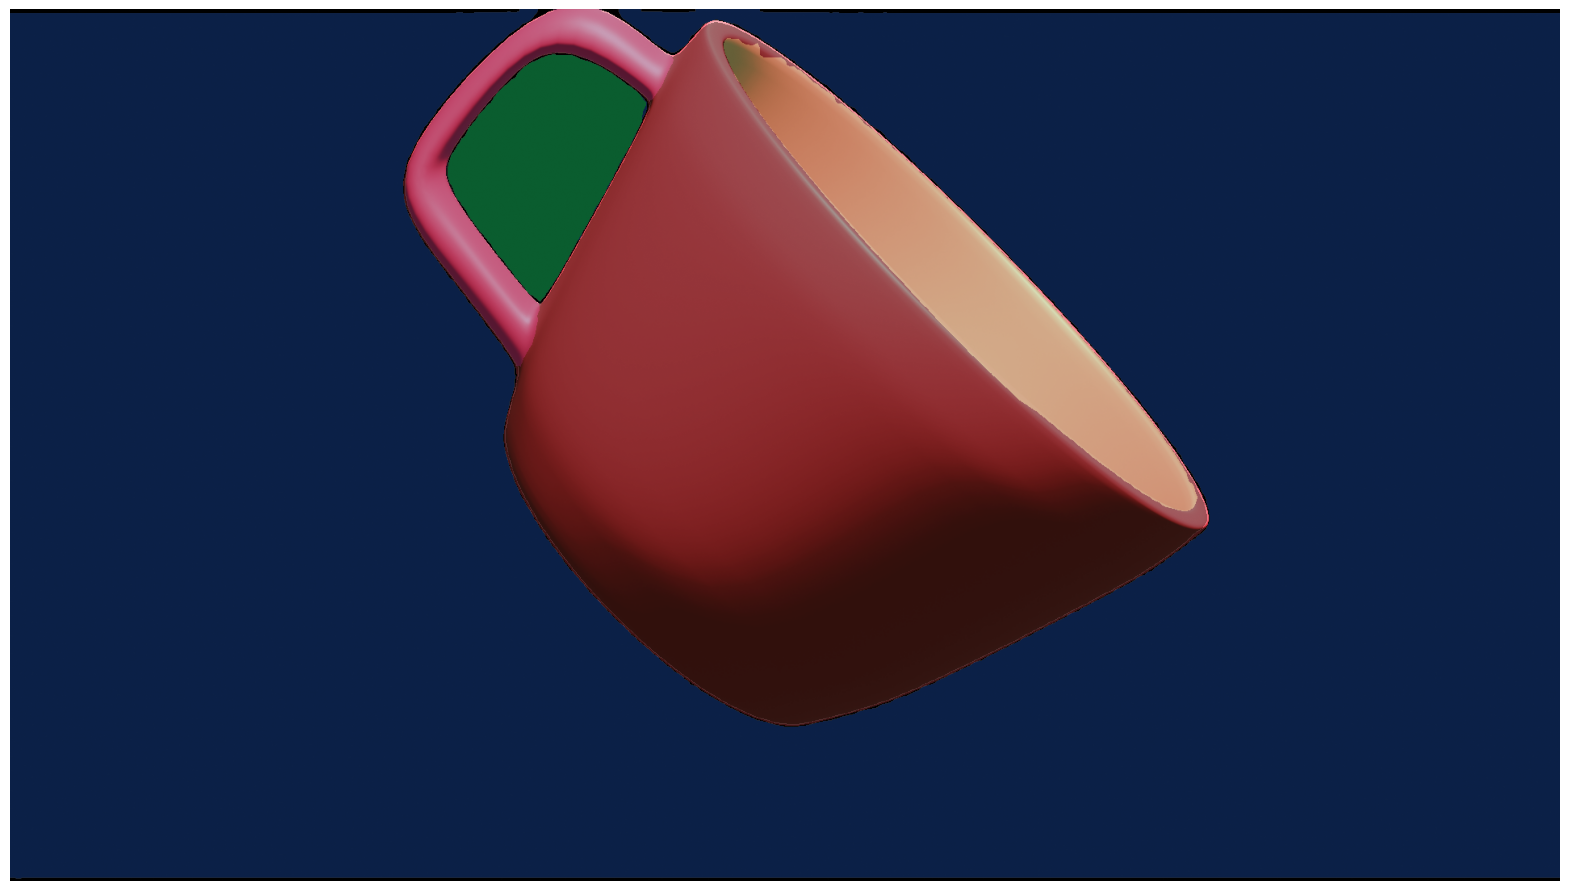

In [40]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

In [31]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8, # Number of points to be sampled along one side of the image. Total number of points is this squared.
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [32]:
masks2 = mask_generator_2.generate(image)

In [33]:
len(masks2)

5

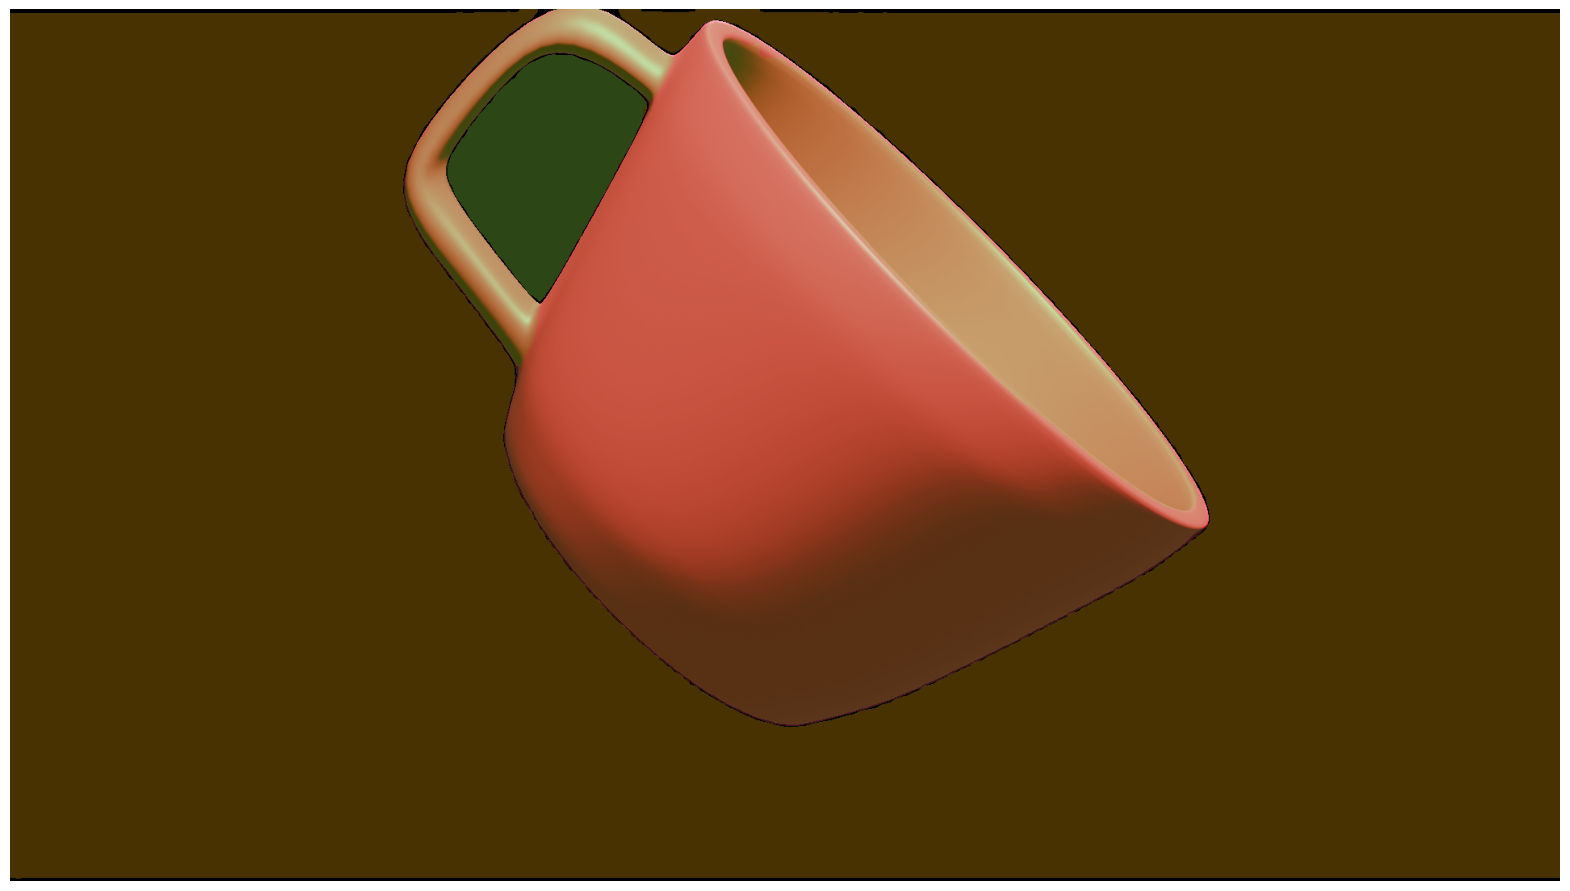

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

[[840.0, 607.5]]
Area of mask =  489853
Point inside mask:  True


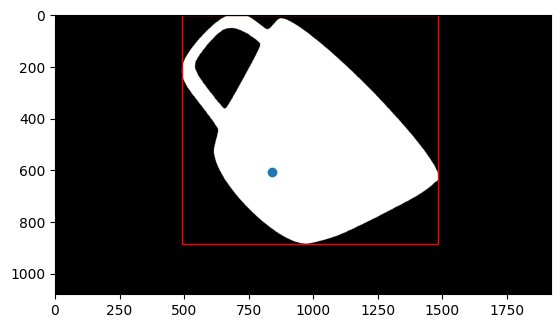

[[600.0, 472.5]]
Area of mask =  1556904
Point inside mask:  True


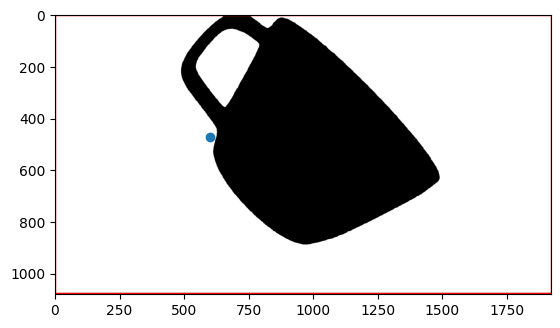

[[600.0, 67.5]]
Area of mask =  33824
Point inside mask:  True


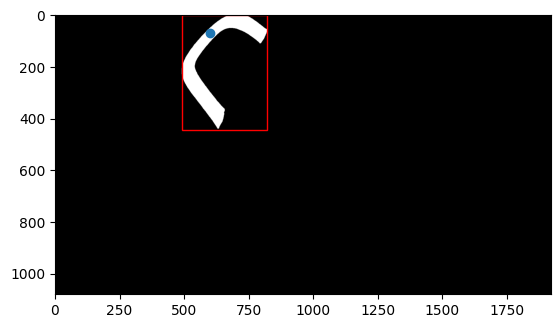

[[1320.0, 472.5]]
Area of mask =  74059
Point inside mask:  True


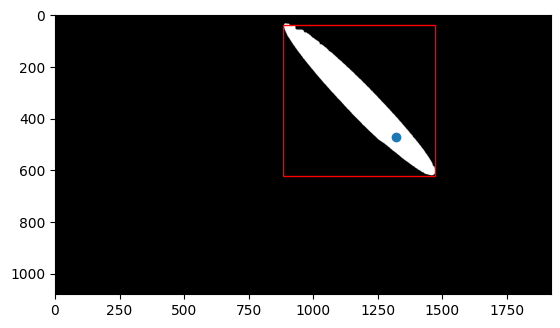

[[600.0, 202.5]]
Area of mask =  44080
Point inside mask:  True


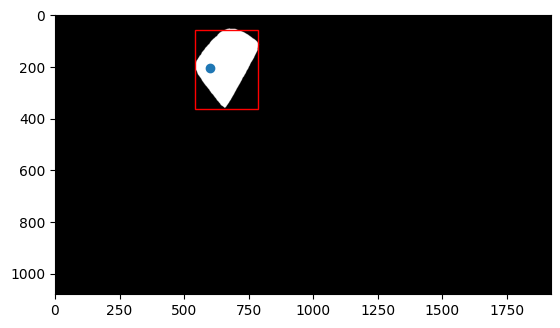

In [35]:
for mask in masks2:
    segmented_mask = mask['segmentation']
    input_points = mask['point_coords']
    print(input_points)
    print("Area of mask = ", mask['area'])

    bb = mask['bbox']
    rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
    
    # values, counts = np.unique(segmented_mask, return_counts=True)
    # print(values)
    # print(counts)
    
    fig, ax = plt.subplots()
    ax.add_patch(rect)

    plt.imshow(segmented_mask, cmap='gray')
    for point in input_points:
        x, y = point[0], point[1]
        print("Point inside mask: ", segmented_mask[int(y), int(x)])
        plt.plot(x, y, marker="o")
    plt.show()

